In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

In [3]:
hello = tf.constant('Hello, TensorFlow!')

In [4]:
sess = tf.Session()

In [5]:
print(sess.run(hello))

b'Hello, TensorFlow!'


In [6]:
a = tf.constant(10)

In [7]:
b = tf.constant(32)

In [8]:
print(sess.run(a + b))

42


## chapter 14 
### "再帰型ニューラルネットワーク(RNN)"

## 目次
1. RNNの基本概念(p.381~386)
2. TensorFlowによるRNNの実装(p.386~391)
3. RNNの訓練と時系列データの訓練(p.391~398)
4. 創造的シーケンス(p.398~399)
5. 深層RNN(p.399~403)
6. LSTMセル(p.403~406)
7. GRUセル(p.406~407)
8. 自然言語処理(p.408~412)

# Basic RNN

## Manual RNN

In [9]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [10]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
print(Y0_val)

[[-0.06640061  0.9625767   0.6810579   0.7091854  -0.89821595]
 [ 0.99777555 -0.7197888  -0.99657613  0.96739244 -0.99989706]
 [ 0.99999785 -0.9989881  -0.99999887  0.9967763  -0.9999999 ]
 [ 1.         -1.         -1.         -0.9981892   0.9995087 ]]


In [12]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200272 -0.99999994]
 [-0.12210429  0.62805295  0.96718436 -0.9937122  -0.2583933 ]
 [ 0.99999815 -0.9999994  -0.99999744 -0.8594331  -0.99998796]
 [ 0.99928296 -0.9999981  -0.9999059   0.98579615 -0.9220575 ]]


## Using static_rnn()

In [13]:
n_inputs = 3
n_neurons = 5

In [14]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

/.pyenv/versions/anaconda3-5.2.0/envs/tensorflowGPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
init = tf.global_variables_initializer()

In [16]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [17]:
Y0_val

array([[ 0.30741337, -0.32884312, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.9912275 , -0.95425415, -0.7518078 , -0.9995208 ,  0.98202336],
       [ 0.99992675, -0.99783254, -0.82473516, -0.99999636,  0.99947786],
       [ 0.9967709 , -0.6875061 ,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [18]:
Y1_val

array([[ 0.99998885, -0.9997606 , -0.06679297, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.5152086 , -0.37968948, -0.5922594 , -0.08968376],
       [ 0.998624  , -0.99715203, -0.03308632, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

In [20]:
from tensorflow_graph_in_jupyter import show_graph

In [21]:
show_graph(tf.get_default_graph())

In [24]:
show_graph()

TypeError: show_graph() missing 1 required positional argument: 'graph_def'

## Packing sequences

In [25]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [27]:
init = tf.global_variables_initializer()

In [28]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [29]:
print(outputs_val)

[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]]


In [30]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]
 [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]
 [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]
 [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]


## Using dynamic_rnn()

In [31]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [33]:
init = tf.global_variables_initializer()

In [34]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [35]:
print(outputs_val)

[[[-0.09488751 -0.78635406 -0.7597686   0.8145645  -0.8659666 ]
  [-0.99999815 -0.9998991  -0.99999416  0.99959815 -0.40855828]]

 [[-0.9882368  -0.99379843 -0.9984831   0.9940736  -0.9553898 ]
  [ 0.21658953 -0.20340657  0.0259128   0.44528607 -0.401168  ]]

 [[-0.9999153  -0.99983823 -0.99999154  0.99982715 -0.98561245]
  [-0.9998105  -0.99268615 -0.9995288   0.9938599  -0.25559658]]

 [[-0.99883723  0.841985   -0.9726714  -0.8698429   0.999127  ]
  [-0.97511077 -0.3484098  -0.9212814   0.39821982  0.2795389 ]]]


In [36]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [37]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [38]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [39]:
init = tf.global_variables_initializer()

In [40]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [42]:
print(outputs_val)

[[[ 0.731557    0.3483572   0.50582004 -0.22882834 -0.4402272 ]
  [-0.61832327  0.99999994  0.865848    0.97933763  0.99022454]]

 [[ 0.84387034  0.9969754   0.84789455  0.43032196  0.09275493]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.9115923   0.9999905   0.9595445   0.8189222   0.5774024 ]
  [-0.7754546   0.99987745  0.9784728   0.7317201   0.8887761 ]]

 [[-0.99952275  0.9997785   0.5974465   0.99309695  0.9984741 ]
  [-0.62119997  0.5400083   0.9693844   0.19893228  0.19448037]]]


In [43]:
print(states_val)

[[-0.61832327  0.99999994  0.865848    0.97933763  0.99022454]
 [ 0.84387034  0.9969754   0.84789455  0.43032196  0.09275493]
 [-0.7754546   0.99987745  0.9784728   0.7317201   0.8887761 ]
 [-0.62119997  0.5400083   0.9693844   0.19893228  0.19448037]]


## Training a sequence classifier

In [44]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [45]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [46]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94666666 Test accuracy: 0.9366001
1 Train accuracy: 0.9666667 Test accuracy: 0.9486001
2 Train accuracy: 0.9533334 Test accuracy: 0.95870006
3 Train accuracy: 0.94000006 Test accuracy: 0.9609002
4 Train accuracy: 0.96000004 Test accuracy: 0.95920014
5 Train accuracy: 0.9666667 Test accuracy: 0.96530014
6 Train accuracy: 0.98 Test accuracy: 0.9713001
7 Train accuracy: 0.98 Test accuracy: 0.9716002
8 Train accuracy: 0.93999994 Test accuracy: 0.97120017
9 Train accuracy: 0.97333336 Test accuracy: 0.96990013
10 Train accuracy: 0.98 Test accuracy: 0.97150016
11 Train accuracy: 0.9466667 Test accuracy: 0.9687002
12 Train accuracy: 0.99333334 Test accuracy: 0.9754002
13 Train accuracy: 0.98 Test accuracy: 0.97210014
14 Train accuracy: 0.9866667 Test accuracy: 0.97720015
15 Train accuracy: 0.99333334 Test accuracy: 0.97440016
16 Train accuracy: 1.0 Test accuracy: 0.9786001
17 Train accuracy: 0.9866667 Test accuracy: 0.97040015
18 Train accuracy: 0.98 Test accuracy: 0.977500

## Multi layer RNN

In [47]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [48]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [49]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [50]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94666666 Test accuracy: 0.94320005
1 Train accuracy: 0.98 Test accuracy: 0.9548001
2 Train accuracy: 0.9533334 Test accuracy: 0.9672001
3 Train accuracy: 0.99333334 Test accuracy: 0.9766001
4 Train accuracy: 0.97333336 Test accuracy: 0.97360015
5 Train accuracy: 0.97333336 Test accuracy: 0.9597001
6 Train accuracy: 0.98 Test accuracy: 0.9758001
7 Train accuracy: 0.9866667 Test accuracy: 0.97860014
8 Train accuracy: 1.0 Test accuracy: 0.97790015
9 Train accuracy: 0.99333334 Test accuracy: 0.98140013


## Time Series

In [51]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/rnn/time_series_plot.png'

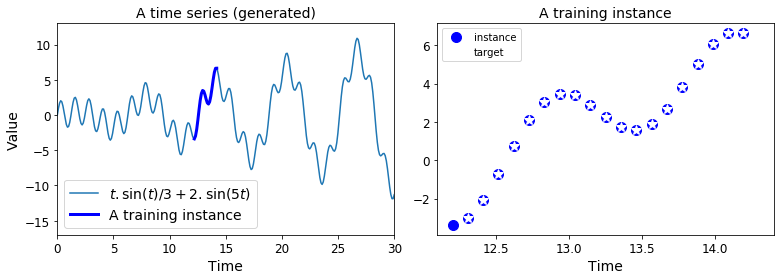

In [52]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [53]:
X_batch, y_batch = next_batch(1, n_steps)

In [54]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an OuputProjectionWrapper(p.394~)

In [55]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [56]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [57]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [58]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [59]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [60]:
saver = tf.train.Saver()

In [61]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 18.917656
100 	MSE: 0.7625432
200 	MSE: 0.29067826
300 	MSE: 0.15128386
400 	MSE: 0.07760262
500 	MSE: 0.06675793
600 	MSE: 0.062389124
700 	MSE: 0.05461351
800 	MSE: 0.05490942
900 	MSE: 0.0517202
1000 	MSE: 0.053288717
1100 	MSE: 0.05126873
1200 	MSE: 0.044732906
1300 	MSE: 0.053004723
1400 	MSE: 0.04580348


In [62]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})


INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [63]:
y_pred

array([[[-3.4243748 ],
        [-2.4659483 ],
        [-1.1470705 ],
        [ 0.69752693],
        [ 2.1403756 ],
        [ 3.0932178 ],
        [ 3.5103838 ],
        [ 3.268903  ],
        [ 2.7139637 ],
        [ 2.1352558 ],
        [ 1.6026199 ],
        [ 1.525563  ],
        [ 1.9222052 ],
        [ 2.6930225 ],
        [ 3.7894285 ],
        [ 5.0569415 ],
        [ 6.0674186 ],
        [ 6.6396675 ],
        [ 6.605341  ],
        [ 5.984899  ]]], dtype=float32)

Saving figure time_series_pred_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/rnn/time_series_pred_plot.png'

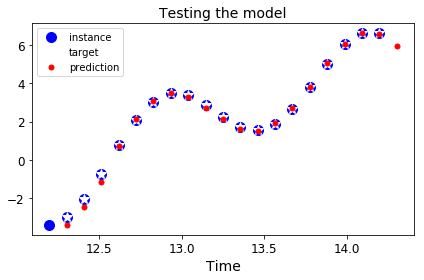

In [64]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an OutputProjectionWrapper(p.397~)

In [65]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [66]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [67]:
n_outputs = 1
learning_rate = 0.001

In [68]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [69]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [70]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 10.162243
100 	MSE: 0.4067183
200 	MSE: 0.11422509
300 	MSE: 0.06893537
400 	MSE: 0.06902411
500 	MSE: 0.06328662
600 	MSE: 0.058171473
700 	MSE: 0.050235596
800 	MSE: 0.051858764
900 	MSE: 0.050891843
1000 	MSE: 0.0493742
1100 	MSE: 0.050597522
1200 	MSE: 0.042348832
1300 	MSE: 0.04763121
1400 	MSE: 0.042118482


In [71]:
y_pred

array([[[-3.4078481 ],
        [-2.460995  ],
        [-1.0683073 ],
        [ 0.83847743],
        [ 2.1880014 ],
        [ 3.0238774 ],
        [ 3.4237194 ],
        [ 3.3501875 ],
        [ 2.8977578 ],
        [ 2.218427  ],
        [ 1.6081125 ],
        [ 1.4643531 ],
        [ 1.8570658 ],
        [ 2.7308815 ],
        [ 3.9800828 ],
        [ 5.2207704 ],
        [ 6.12554   ],
        [ 6.6400075 ],
        [ 6.5762644 ],
        [ 5.985511  ]]], dtype=float32)

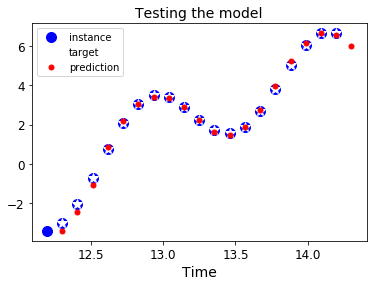

In [72]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence(p.398~)

In [73]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


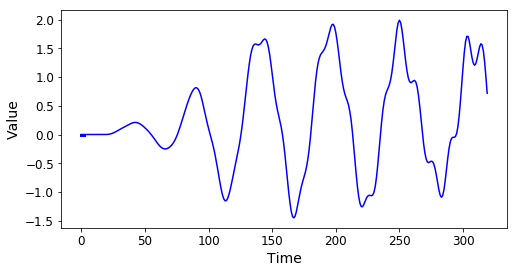

In [74]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/rnn/creative_sequence_plot.png'

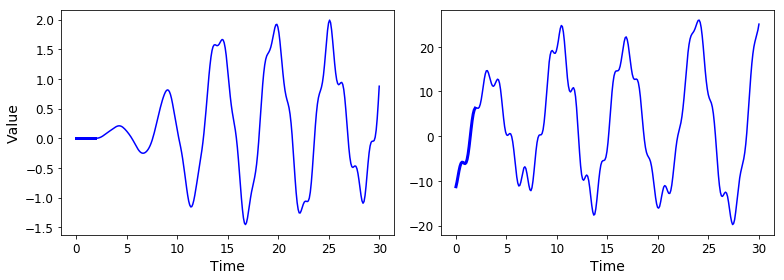

In [75]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

## Deep RNN(p.399~)

In [76]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [77]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [78]:
init = tf.global_variables_initializer()

In [79]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [80]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [81]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs(p.400~)

In [82]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [83]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [84]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [85]:
init = tf.global_variables_initializer()

In [86]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[ 0.06828325 -0.11375451  0.06424566 ... -0.24244198 -0.04821674
   -0.12077257]
  [ 0.07453813 -0.2251049   0.20471548 ... -0.14811224 -0.0922538
   -0.04429063]
  [ 0.13780868 -0.14680631 -0.0095655  ... -0.08136044  0.07381541
   -0.03125775]
  ...
  [-0.25400278 -0.3207855   0.39923593 ... -0.26669216  0.3350577
   -0.03757669]
  [ 0.22596692 -0.09880773 -0.27422303 ... -0.13385999 -0.25443044
   -0.36498186]
  [ 0.1655937  -0.33435836  0.34313348 ... -0.36904442  0.06908746
    0.46574104]]

 [[ 0.00489879 -0.03151967  0.02628033 ... -0.19341362 -0.0730375
    0.00451888]
  [ 0.03073939 -0.0579551   0.17785911 ... -0.20945786  0.05200011
   -0.07436937]
  [ 0.00192378 -0.25690764  0.12488247 ...  0.02644884 -0.25046453
   -0.12239399]
  ...
  [-0.13501379 -0.06209698  0.1595035  ... -0.2001212  -0.3338365
   -0.09281697]
  [-0.44347292  0.2032327   0.1252696  ... -0.07962411  0.27046496
    0.3188401 ]
  [ 0.23965777 -0.22903362  0.07749593 ... -0.02653922  0.084024
    0.023136

## Dropout(p.401~)

In [87]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [88]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [89]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [90]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 14.964677
100 Training MSE: 4.8932004
200 Training MSE: 3.7484088
300 Training MSE: 3.9137127
400 Training MSE: 2.9819317
500 Training MSE: 2.7450898
600 Training MSE: 3.5939262
700 Training MSE: 3.987208
800 Training MSE: 3.7374578
900 Training MSE: 4.612724
1000 Training MSE: 5.7204022
1100 Training MSE: 5.937372
1200 Training MSE: 5.3921742
1300 Training MSE: 4.508759
1400 Training MSE: 4.909577


In [92]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


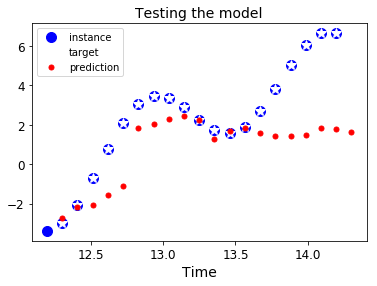

In [93]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## LSTM(p.403~)

In [94]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

In [95]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [96]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [97]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [98]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.94666666 Test accuracy = 0.9515001
Epoch 1 Train accuracy = 0.97333336 Test accuracy = 0.9680001
Epoch 2 Train accuracy = 0.9866666 Test accuracy = 0.97470015
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9740001
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9787001
Epoch 5 Train accuracy = 0.98 Test accuracy = 0.98430014
Epoch 6 Train accuracy = 1.0 Test accuracy = 0.9873001
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.98720014
Epoch 8 Train accuracy = 0.99333334 Test accuracy = 0.9848002
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9867002


In [99]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [100]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

## Natural language processing(p.408~)

## Embeddings(p.408~)

## Fetch the data

In [101]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [102]:
words = fetch_words_data()

In [103]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [104]:
words[5:]

['of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 'interpretations',
 'of',
 'what',
 'this',
 'means'

In [106]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [107]:
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [108]:
words.shape

AttributeError: 'list' object has no attribute 'shape'

In [109]:
type[words]

TypeError: 'type' object is not subscriptable

## Build the dictionary(p.408~)

In [110]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [111]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [112]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [113]:
words[24], data[24]

('culottes', 0)

## Generate baches

In [114]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [115]:
np.random.seed(42)

In [116]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [117]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [119]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [120]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01


In [121]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [122]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [123]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [ ]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

### attention"keepdims->keep_dims"

## Train the model

In [128]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  279.1802673339844
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, richards, egyptians, legionnaires, leonel, opener,
Nearest to up: clair, drives, steadfast

In [129]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [130]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

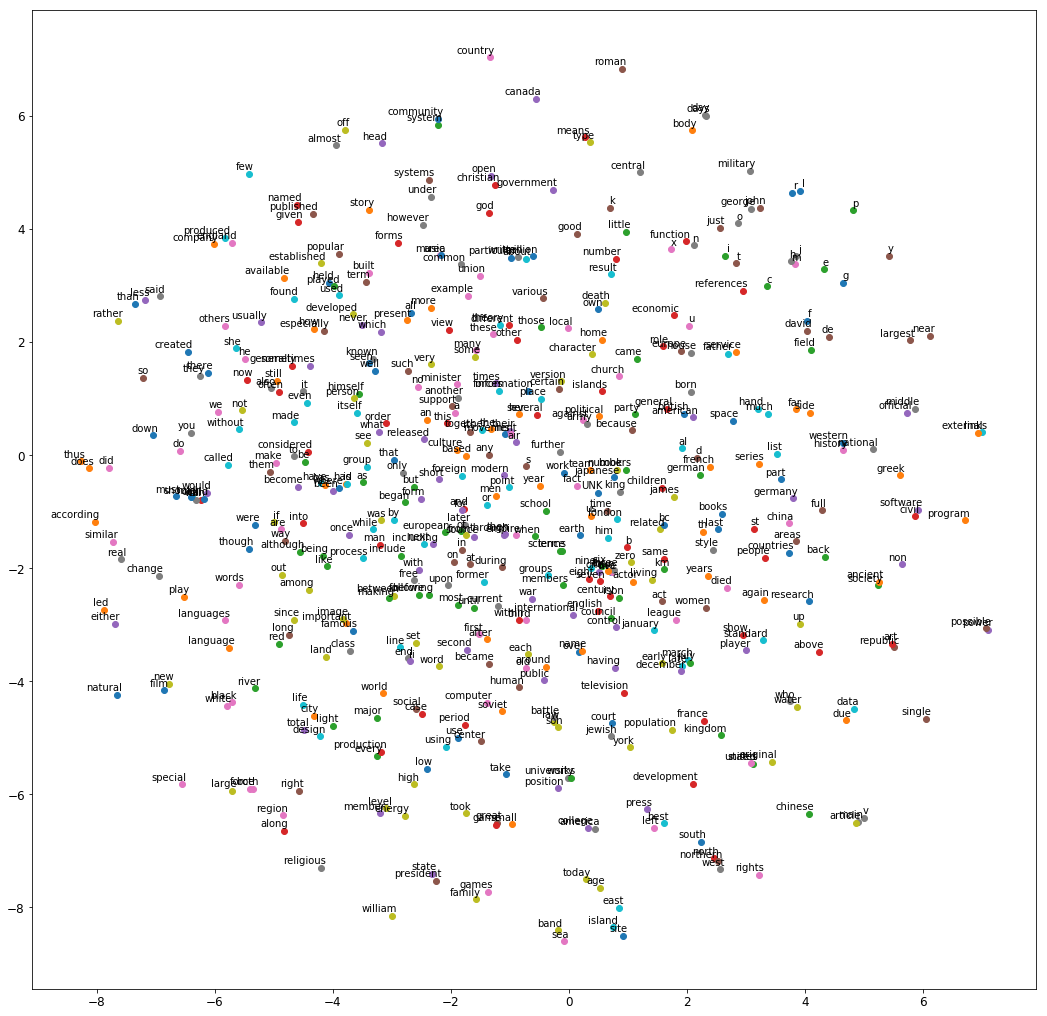

In [131]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Machine translation(p.409~)

In [132]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [133]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()